# Libraries

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from data_loader_for_cv import MyDataLoader

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import f1_score, confusion_matrix

from monai.data import Dataset, DataLoader
from monai.networks.nets import EfficientNetBN

import matplotlib.pyplot as plt

# Data

In [2]:
dataloader = MyDataLoader(
    csv_path="../../../data/data.csv",
    input_shape=(128, 128, 32),
    config={"batch_size": 2, "num_workers": 4},
    transformations=None,
    num_classes=2
)

all_data = dataloader.get_all_data()

all_labels = []
for item in all_data:
    cls_idx = torch.argmax(item["label"]).item()
    all_labels.append(int(cls_idx))

patient_ids = [item["patient_id"] for item in all_data]

# Train

In [3]:
n_splits = 2
splitter = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)

results_rows = []

best_overall_model = None
best_overall_score = -np.inf
best_split_info = (None, None)

for split_index, (train_idx, val_idx) in enumerate(splitter.split(all_data, all_labels, groups=patient_ids), start=1):
    print(f"\n=== Split {split_index}/{n_splits} ===")

    train_subset = [all_data[i] for i in train_idx]
    val_subset = [all_data[i] for i in val_idx]
    
    class_counts = torch.zeros(2, dtype=torch.long)
    for item in train_subset:
        cls_idx = torch.argmax(item["label"]).item()
        class_counts[cls_idx] += 1

    train_len = len(train_subset)
    weights_list = []
    for c in range(2):
        count_c = class_counts[c].item() if class_counts[c] > 0 else 1e-6
        weights_list.append(train_len / count_c)

    weights_tensor = torch.tensor(weights_list, dtype=torch.float32)
    class_weights = weights_tensor / weights_tensor.sum()

    train_dataset = Dataset(data=train_subset, transform=dataloader.get_transforms(augment=True))
    val_dataset = Dataset(data=val_subset, transform=dataloader.get_transforms(augment=False))

    train_loader = DataLoader(train_dataset, batch_size=2, num_workers=4, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=2, num_workers=4, shuffle=False)

    model = EfficientNetBN(
        spatial_dims=3,
        in_channels=3,
        num_classes=2,
        model_name='efficientnet-b0',
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

    epochs = 5

    best_split_model_state = None
    best_split_val_f1 = -np.inf
    best_split_epoch = 0

    for epoch in range(1, epochs + 1):
        # --------------------- Entrenamiento ---------------------
        model.train()
        train_loss_acum = 0.0
        preds_list = []
        labels_list = []

        for batch in train_loader:
            inputs = batch["image"].to(device)
            label_hot = batch["label"].to(device)
            label_cls = torch.argmax(label_hot, dim=1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, label_cls)
            loss.backward()
            optimizer.step()

            train_loss_acum += loss.item()

            pred_cls = torch.argmax(outputs, dim=1)
            preds_list.append(pred_cls.cpu())
            labels_list.append(label_cls.cpu())

        train_loss = train_loss_acum / len(train_loader)
        preds_cat = torch.cat(preds_list)
        labels_cat = torch.cat(labels_list)
        train_f1 = f1_score(labels_cat.numpy(), preds_cat.numpy(), average='binary')

        # --------------------- Validación ---------------------
        model.eval()
        val_loss_acum = 0.0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for batch in val_loader:
                inputs = batch["image"].to(device)
                label_hot = batch["label"].to(device)
                label_cls = torch.argmax(label_hot, dim=1)

                outputs = model(inputs)
                loss = criterion(outputs, label_cls)
                val_loss_acum += loss.item()

                pred_cls = torch.argmax(outputs, dim=1)
                val_preds.append(pred_cls.cpu())
                val_labels.append(label_cls.cpu())

        val_loss = val_loss_acum / len(val_loader)
        val_preds_cat = torch.cat(val_preds)
        val_labels_cat = torch.cat(val_labels)
        val_f1 = f1_score(val_labels_cat.numpy(), val_preds_cat.numpy(), average='binary')

        print(f"Split {split_index}, Epoch [{epoch}/{epochs}] | "
              f"Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f} || "
              f"Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}")

        results_rows.append({
            "split": split_index,
            "epoch": epoch,
            "train_loss": train_loss,
            "train_f1": train_f1,
            "val_loss": val_loss,
            "val_f1": val_f1
        })

        if val_f1 > best_split_val_f1:
            best_split_val_f1 = val_f1
            best_split_epoch = epoch
            best_split_model_state = model.state_dict()

    if best_split_val_f1 > best_overall_score:
        best_overall_score = best_split_val_f1
        best_split_info = (split_index, best_split_epoch)
        best_overall_model = best_split_model_state


=== Split 1/2 ===


KeyboardInterrupt: 

In [17]:
df_results = pd.DataFrame(results_rows)
# df_results.to_csv("cv_training_history.csv", index=False)

# Graphs

## Evolución por épocas

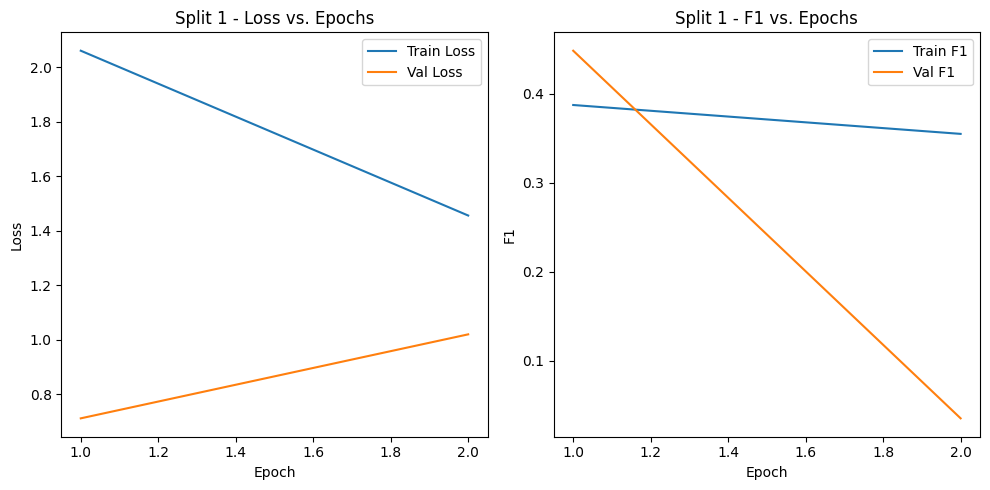

In [8]:
split_1_data = df_results[df_results["split"] == 1]
epochs_list = split_1_data["epoch"].tolist()

plt.figure(figsize=(10, 5))

# Gráfica de pérdida (loss)
plt.subplot(1, 2, 1)
plt.plot(epochs_list, split_1_data["train_loss"], label="Train Loss")
plt.plot(epochs_list, split_1_data["val_loss"], label="Val Loss")
plt.title("Split 1 - Loss vs. Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Gráfica de F1
plt.subplot(1, 2, 2)
plt.plot(epochs_list, split_1_data["train_f1"], label="Train F1")
plt.plot(epochs_list, split_1_data["val_f1"], label="Val F1")
plt.title("Split 1 - F1 vs. Epochs")
plt.xlabel("Epoch")
plt.ylabel("F1")
plt.legend()

plt.tight_layout()
plt.show()

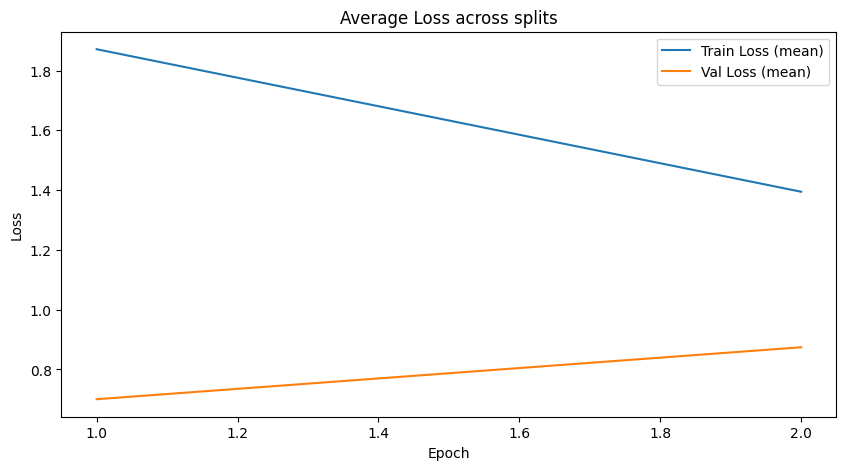

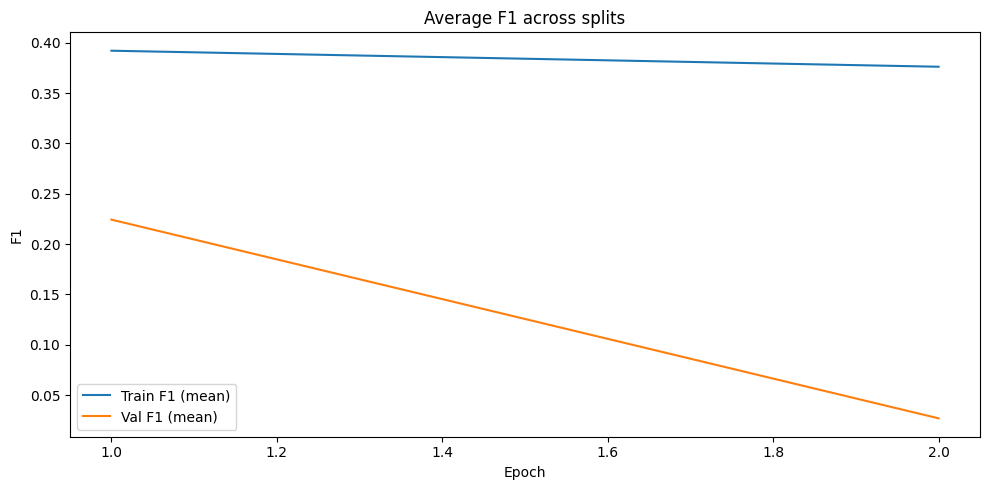

In [9]:
df_mean = df_results.groupby("epoch").mean().reset_index()

plt.figure(figsize=(10, 5))

# Gráfica de pérdida promedio
plt.plot(df_mean["epoch"], df_mean["train_loss"], label="Train Loss (mean)")
plt.plot(df_mean["epoch"], df_mean["val_loss"], label="Val Loss (mean)")
plt.title("Average Loss across splits")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.figure(figsize=(10, 5))

# Gráfica de F1 promedio
plt.plot(df_mean["epoch"], df_mean["train_f1"], label="Train F1 (mean)")
plt.plot(df_mean["epoch"], df_mean["val_f1"], label="Val F1 (mean)")
plt.title("Average F1 across splits")
plt.xlabel("Epoch")
plt.ylabel("F1")
plt.legend()

plt.tight_layout()
plt.show()

## Matriz de confusión

In [16]:
best_split, best_epoch = best_split_info
print(f"El mejor modelo fue en split={best_split}, epoch={best_epoch}, con val_f1={best_overall_score:.4f}")

best_model = EfficientNetBN(
    spatial_dims=3,
    in_channels=3,
    num_classes=2,
    model_name='efficientnet-b0',
)
best_model.load_state_dict(best_overall_model)
best_model = best_model.to(device)
best_model.eval()

splitter = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)
split_indices = list(splitter.split(all_data, all_labels, groups=patient_ids))
train_idx, val_idx_to_use = split_indices[best_split - 1]

val_subset_best = [all_data[i] for i in val_idx_to_use]

val_dataset_best = Dataset(
    data=val_subset_best,
    transform=dataloader.get_transforms(augment=False)
)
val_loader_best = DataLoader(val_dataset_best, batch_size=2, num_workers=4, shuffle=False)

all_preds = []
all_targets = []

with torch.no_grad():
    for batch in val_loader_best:
        inputs = batch["image"].to(device)
        label_hot = batch["label"].to(device)
        label_cls = torch.argmax(label_hot, dim=1)

        outputs = best_model(inputs)
        preds = torch.argmax(outputs, dim=1)

        all_preds.append(preds.cpu())
        all_targets.append(label_cls.cpu())

all_preds_cat = torch.cat(all_preds)
all_targets_cat = torch.cat(all_targets)

cm = confusion_matrix(all_targets_cat.numpy(), all_preds_cat.numpy())
print("Matriz de confusión (Mejor modelo):")
print(cm)

El mejor modelo fue en split=1, epoch=1, con val_f1=0.4486


RuntimeError: Too many open files. Communication with the workers is no longer possible. Please increase the limit using `ulimit -n` in the shell or change the sharing strategy by calling `torch.multiprocessing.set_sharing_strategy('file_system')` at the beginning of your code

In [15]:
val_idx_to_use

array([0])

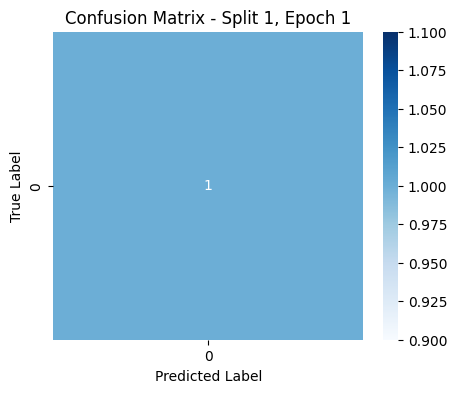

In [11]:
import seaborn as sns

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix - Split {best_split}, Epoch {best_epoch}")
plt.show()